## OSM network_type = "cycle" - Untersuchen von "surface"
------- 

Für unser Vorhersagemodell wollen wir die Oberflächenbeschaffenheit (surface) der Straßen mit einbeziehen.  

Dazu wollen wir folgendes untersuchen:
* Welche Arten von Oberflächen existieren?
* Sind für alle Straßen Werte eingetragen, gibt es null-Werte?
* Welche Oberflächenkategorien kann man evtl. zusammenfassen?

Über Geofabrik wurden die OSM-Daten für die Stadt Berlin als pbf (Protocolbuffer Binary Format) heruntergeladen.  
Mittels pyrosm wird ein OSM-Objekt erstellt, um effizienter auf Daten zugreifen zu können.  

Da wir nur Straßen betrachten wollen, auf denen Fahrradfahren möglich ist, extrahieren mit get_network(network_type=cycle) genau diese Straßen und speichern sie in einem DataFrame (cycle_net_berlin)




In [129]:
# Daten wurden schon geladen und sind im Ordner data abgelegt
import os
import pyrosm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='pyrosm')

# Verzeichnis-Pfad
directory = "../../data"
file_path = os.path.join(directory, "berlin-latest.osm.pbf")

# OSM-Objekt erstellen
berlin_osm = pyrosm.OSM(file_path)

# Fahrradnetzwerk extrahieren
cycle_net_berlin = berlin_osm.get_network(network_type="cycling")


### Welche Arten von Oberflächen existieren?

* Es gibt insgesamt 36 verschiedene Werte, die für surface gesetzt wurden. Das ist eine zu kleinteilige Unterteilung für unser Modell und könnte das Trainieren eines guten Modells erschweren
* Knapp über ein Drittel der Straßen (36,55%) haben keinen gesetzten Wert. Es liegt also keine Information zu surface vor.

  
Folgende Überlegungen und weiteres Vorgehen:
* Welche Values von surface sind ähnlich und könnten zusammengefasst werden?
* Welche Arten von Straßen haben keine gesetzten Wert? Gibt es Häufungen?



Die Gesamtzahl der Straßen ist: 177849
Die Anzahl der Straßen ohne 'surface'-Wert ist: 65001
Prozentualer Anteil der Straßen ohne 'surface'-Wert: 36.55%
                                     surface  Anzahl Strassen
0                                    No Data            65001
1                                    asphalt            57625
2                              paving_stones            18270
3                                       sett            12662
4                                   concrete             8672
5                                       dirt             3789
6                                     ground             3345
7                                  compacted             1838
8                                fine_gravel             1246
9                                      grass              989
10                           concrete:plates              579
11                                      sand              555
12                               cobblest

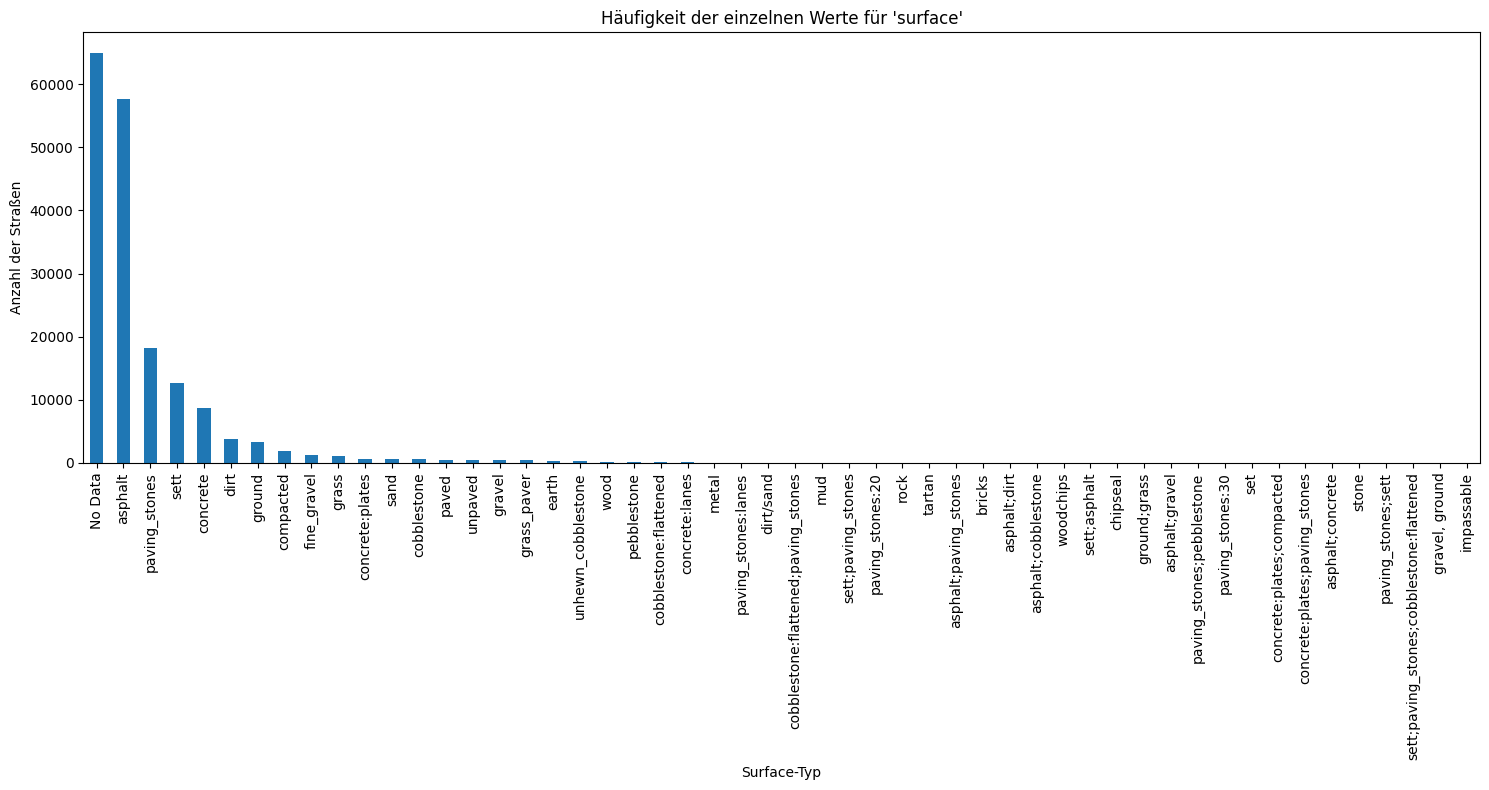

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# Zähle die Vorkommen jedes Wertes in der Spalte 'surface'
surface_counts = cycle_net_berlin['surface'].value_counts(dropna=False).reset_index()
surface_counts.columns = ['surface', 'Anzahl Strassen']

# Ersetzen von NaN durch "No Data"
surface_counts['surface'] = surface_counts['surface'].fillna('No Data')

# Gesamtzahl der Straßen berechnen
gesamtzahl_strassen = surface_counts['Anzahl Strassen'].sum()

# Anzahl der Straßen ohne surface-Wert (NaN)
anzahl_no_data = surface_counts[surface_counts['surface'].isna()]['Anzahl Strassen'].sum()

# Falls wir 'No Data' als Text haben statt NaN
anzahl_no_data += surface_counts[surface_counts['surface'] == 'No Data']['Anzahl Strassen'].sum()

# Prozentsatz berechnen
prozent_no_data = (anzahl_no_data / gesamtzahl_strassen) * 100

print(f"Die Gesamtzahl der Straßen ist: {gesamtzahl_strassen}")
print(f"Die Anzahl der Straßen ohne 'surface'-Wert ist: {anzahl_no_data}")
print(f"Prozentualer Anteil der Straßen ohne 'surface'-Wert: {prozent_no_data:.2f}%")


print(surface_counts)


# Setze die 'surface'-Spalte als Index
surface_counts.set_index('surface', inplace=True)
plt.figure(figsize=(15, 8))
surface_counts['Anzahl Strassen'].plot(kind='bar')
plt.title("Häufigkeit der einzelnen Werte für 'surface'")
plt.xlabel("Surface-Typ")
plt.ylabel("Anzahl der Straßen")
plt.xticks(rotation=90)  # Drehe die x-Achsen-Beschriftungen, weil sonst nicht richtign angezeigt
plt.tight_layout()  # Passt das Layout an, damit alles gut lesbar ist
plt.show()

Die Gesamtzahl der Straßen ist: 177876
Die Anzahl der Straßen ohne 'surface'-Wert ist: 65001
Prozentualer Anteil der Straßen ohne 'surface'-Wert: 36.54%
                  surface  Anzahl Strassen
0                 asphalt            57635
1           paving_stones            18287
2                    sett            12669
3                concrete             8673
4                    dirt             3791
5                  ground             3346
6               compacted             1839
7             fine_gravel             1246
8                   grass              990
9         concrete:plates              581
10                   sand              555
11            cobblestone              541
12                  paved              492
13                unpaved              465
14                 gravel              463
15            grass_paver              372
16                  earth              246
17     unhewn_cobblestone              216
18                   wood     

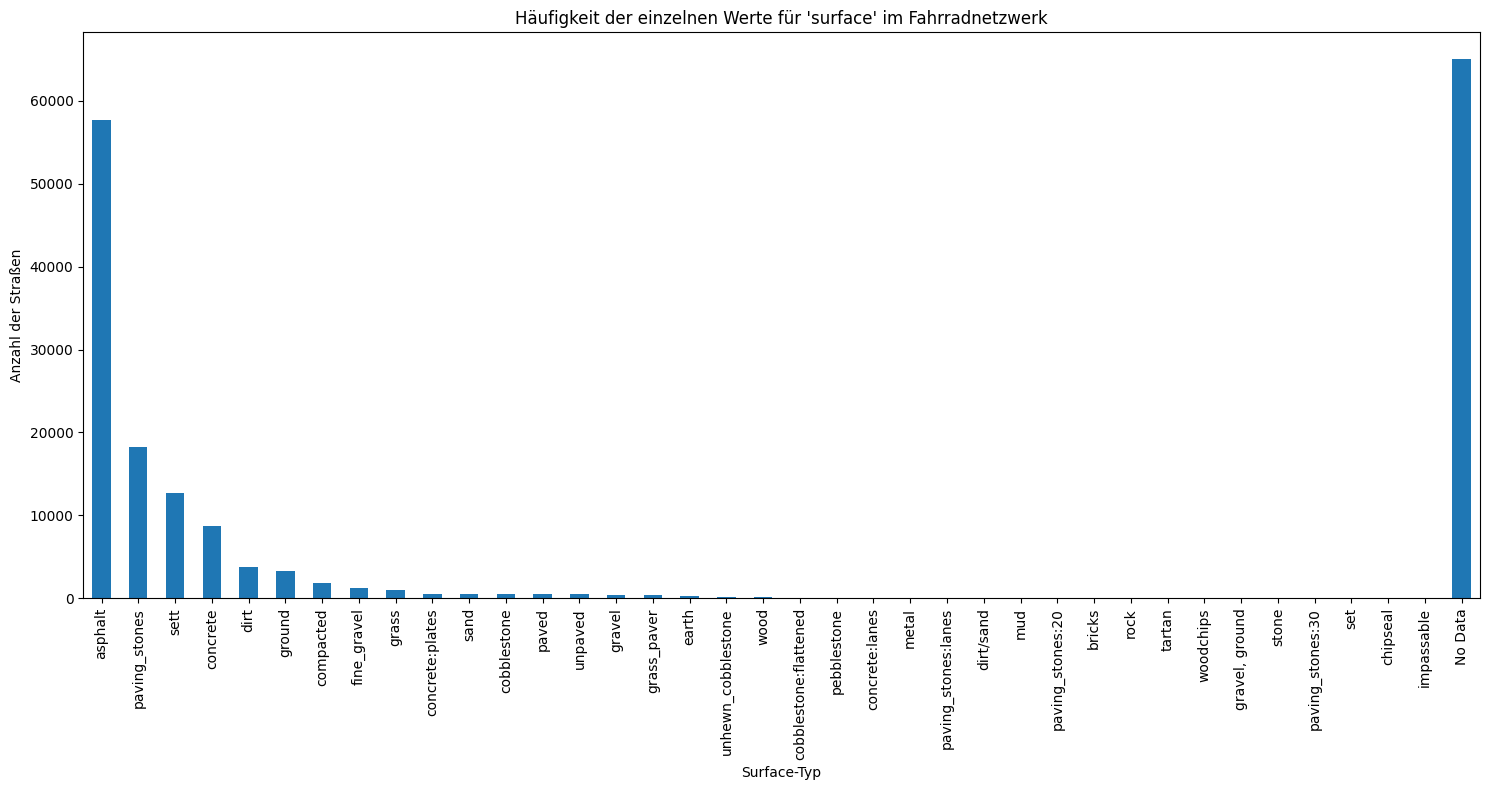

In [131]:
# Funktion zur Aufteilung der Oberflächenwerte und zur Berechnung der Häufigkeiten
def split_surface_counts(df, column='surface'):
    # Aufteilen der Oberflächenwerte
    surface_split = df[column].dropna().str.split(';', expand=True).stack().reset_index(level=1, drop=True)
    surface_split = surface_split.apply(lambda x: x.strip())  # Entfernen von Leerzeichen
    # Zählen der Vorkommen jedes Wertes
    surface_counts = surface_split.value_counts().reset_index()
    surface_counts.columns = [column, 'Anzahl Strassen']
    return surface_counts

# Berechne die Häufigkeiten der einzelnen Oberflächenwerte
surface_counts = split_surface_counts(cycle_net_berlin)

# Füge eine Zeile für 'No Data' hinzu
no_data_count = cycle_net_berlin['surface'].isna().sum()
no_data_df = pd.DataFrame({'surface': ['No Data'], 'Anzahl Strassen': [no_data_count]})
surface_counts = pd.concat([surface_counts, no_data_df], ignore_index=True)

# Gesamtzahl der Straßen berechnen
gesamtzahl_strassen = surface_counts['Anzahl Strassen'].sum()

# Prozentsatz der Straßen ohne surface-Wert (No Data) berechnen
prozent_no_data = (no_data_count / gesamtzahl_strassen) * 100

print(f"Die Gesamtzahl der Straßen ist: {gesamtzahl_strassen}")
print(f"Die Anzahl der Straßen ohne 'surface'-Wert ist: {no_data_count}")
print(f"Prozentualer Anteil der Straßen ohne 'surface'-Wert: {prozent_no_data:.2f}%")

print(surface_counts)

# Setze die 'surface'-Spalte als Index
surface_counts.set_index('surface', inplace=True)
plt.figure(figsize=(15, 8))
surface_counts['Anzahl Strassen'].plot(kind='bar')
plt.title("Häufigkeit der einzelnen Werte für 'surface' im Fahrradnetzwerk")
plt.xlabel("Surface-Typ")
plt.ylabel("Anzahl der Straßen")
plt.xticks(rotation=90)  # Drehe die x-Achsen-Beschriftungen, weil sonst nicht richtig angezeigt
plt.tight_layout()  # Passt das Layout an, damit alles gut lesbar ist
plt.show()


### Analyse der Straßen ohne Wert für surface
* Welche Art von Straßen sind das?
> Die Mehrzahl (92%) der Straßen bei denen kein surface angegeben ist, sind Erschließungswege (service)
> Das sind Zugangsstraßen, Parkplätze, Einfahrten..
> 
> Es gibt auch andere Straßentypen, für die kein Wert gesetzt wurde. Die Anzahl ist jedoch relativ klein, so das diese evtl. zu vernachlässigen sind

    
**Es muss entschieden werden, wie mit fehlenden Daten umzugehen ist**    

**--> IDEE:**  
**bei den Straßen, bei denen Werte fehlen, könnte man die sonst am häufigsten vorkommenden surface-Werte für den jeweiligen Straßentypen setzen**  

**"service", "path" und "track" werden deshalb näher betrachtet.** Alle anderen Straßen werden erst einmal nicht berücksichtigt.


  

highway
service          92.192428
path              2.592268
track             1.804588
residential       1.239981
footway           0.981523
cycleway          0.655375
living_street     0.310764
bridleway         0.058461
unclassified      0.033846
tertiary          0.027692
steps             0.020000
elevator          0.016923
construction      0.015384
pedestrian        0.015384
primary           0.009231
secondary         0.007692
street_lamp       0.006154
tertiary_link     0.003077
busway            0.003077
road              0.001538
services          0.001538
rest_area         0.001538
bus_stop          0.001538
Name: proportion, dtype: float64


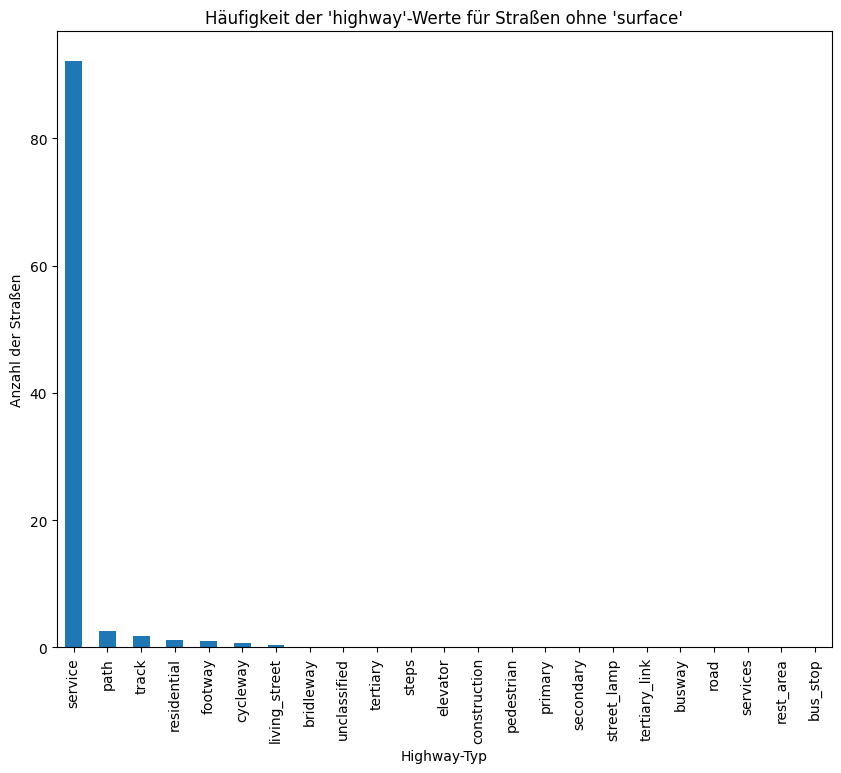

In [132]:
# Filter für Wege ohne Daten in der Spalte "surface"
cycle_net_no_surface = cycle_net_berlin[cycle_net_berlin["surface"].isna()]

# Häufigkeitstabelle für die Werte in der Spalte "highway"
highway_counts = cycle_net_no_surface["highway"].value_counts(normalize=True)*100

# Ausgabe der Häufigkeitstabelle
print(highway_counts)

# Visualisierung der Häufigkeitstabelle als Balkendiagramm
plt.figure(figsize=(10, 8))
highway_counts.plot(kind='bar')
plt.title("Häufigkeit der 'highway'-Werte für Straßen ohne 'surface'")
plt.xlabel("Highway-Typ")
plt.ylabel("Anzahl der Straßen")
plt.show()

### Untersuchen von highway=service 

die häufigsten surface-Werte beim Straßentyp "service" sind:
* **paving_stone** -> Eine Straße mit einer Oberfläche aus Verbundsteinen meist aus Beton gefertigt mit gleichmäßiger, regelmäßiger Form. Die Steine können auch aus gebrannten Ziegeln bestehen. Sie haben daher bei der Verlegung nur schmale Zwischenräume. 
* **asphalt** -> asphaltierte Straße
* **sett** -> Behauenes Steinpflaster (Pflastersteine) mit geglätteter Oberflächen. Diese Steine sind ebener als rohes Kopfsteinpflaster (unhewn_cobblestone) und haben annähernd eine Quaderform. Pflaster aus diesen Steinen sind daher wesentlich angenehmer zu begehen und etwas angenehmer zu befahren.  

**--> Man könnte für fehlende Werte ***surface=paving_stone*** setzen, denn das ist der häufigste vorkommende Wert, zudem ist surface=sett  ähnlich und zusammen bilden sie ein deutliche Mehrheit gegenüber dem häufig gesetzten Wert "asphalt"**  

**ACHTUNG**
Beim Analysieren anderer Städte Deutschlands (siehe notebook [surface_staedte_test](surface_staedte_test.ipynb)) fällt auf, dass die Straßentypen mit fehlenden surface-Werten variieren können und die allg. surface-Werte für die betreffenden Straßen auch anders sein können, als in Berlin.  

**Unser Vorgehen wäre also explizit für Berlin gültig und kann nicht einfach auf andere Städet oder Regionen übertragen werden.**





In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# Zähle die Vorkommen jedes Wertes in der Spalte 'surface'
service_streets = cycle_net_berlin[cycle_net_berlin["highway"] == "service"]


# Ersetzen von NaN durch "No Data"
surface_counts = service_streets['surface'].value_counts(normalize=True)*100


print(surface_counts)


surface
paving_stones                               31.320297
asphalt                                     28.837350
sett                                        18.205245
concrete                                    12.111566
compacted                                    1.609823
grass_paver                                  1.003486
paved                                        0.909504
concrete:plates                              0.873124
fine_gravel                                  0.848871
dirt                                         0.709413
cobblestone                                  0.630590
ground                                       0.618463
grass                                        0.597241
gravel                                       0.372897
unpaved                                      0.360770
sand                                         0.294073
unhewn_cobblestone                           0.181901
pebblestone                                  0.151584
concrete:lanes      

### Untersuchen von highway=path

die häufigsten surface-Werte beim Straßentyp "path" sind:
* **dirt** -> Wird verwendet, wenn die Oberfläche aus freiliegender Erde/Erde/Dreck besteht, aber nicht aus Sand, Kies oder Fels.
* **ground** -> No special surface, the ground itself has marks of human or animal usage. This value gives only a rough description.
* **asphalt** -> asphaltierte Straße
* **paving_stone** -> Eine Straße mit einer Oberfläche aus Verbundsteinen meist aus Beton gefertigt mit gleichmäßiger, regelmäßiger Form. Die Steine können auch aus gebrannten Ziegeln bestehen. Sie haben daher bei der Verlegung nur schmale Zwischenräume. 

**--> Man könnte für fehlende Werte ***surface=dirt*** setzen, denn das ist der häufigste vorkommende Wert, zudem ist surface=ground  ähnlich und zusammen bilden sie ein deutliche Mehrheit gegenüber dem häufig gesetzten Wert "asphalt" und paving_stone**  

**ACHTUNG**
Beim Analysieren anderer Städte Deutschlands (siehe notebook [surface_staedte_test](surface_staedte_test.ipynb)) fällt auf, dass die Straßentypen mit fehlenden surface-Werten variieren können und die allg. surface-Werte für die betreffenden Straßen auch unterscheidlich sein könne, als in Berlin.  

**Unser Vorgehen wäre also explizit für Berlin gültig und kann nicht einfach andere Städte oder Regionen übertragen werden.**

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Zähle die Vorkommen jedes Wertes in der Spalte 'surface'
service_paths = cycle_net_berlin[cycle_net_berlin["highway"] == "path"]


# Ersetzen von NaN durch "No Data"
surface_counts = service_paths['surface'].value_counts(normalize=True)*100


print(surface_counts)

surface
dirt                     27.944251
ground                   27.886179
asphalt                  12.009292
paving_stones            11.881533
grass                     3.344948
compacted                 3.112660
sand                      2.415796
fine_gravel               2.218351
concrete                  1.939605
unpaved                   1.718931
earth                     1.544715
sett                      1.509872
paved                     0.731707
wood                      0.569106
gravel                    0.545877
pebblestone               0.150987
concrete:plates           0.116144
metal                     0.058072
cobblestone:flattened     0.046458
dirt/sand                 0.046458
grass_paver               0.034843
tartan                    0.023229
mud                       0.023229
paving_stones:lanes       0.023229
asphalt;dirt              0.023229
rock                      0.023229
cobblestone               0.023229
ground;grass              0.011614
concrete:lan

### Untersuchen von highway=track

die häufigsten surface-Werte beim Straßentyp "track" sind:
* **dirt** -> Wird verwendet, wenn die Oberfläche aus freiliegender Erde/Erde/Dreck besteht, aber nicht aus Sand, Kies oder Fels.
* **ground** -> No special surface, the ground itself has marks of human or animal usage. This value gives only a rough description.
* **grass** -> Grasbewachsener Boden. Solche Wege verwandeln sich oft in surface=dirt oder werden zugewachsen und verschwinden. Manche Wege wechseln im Laufe des Jahres zwischen surface=dirt und surface=grass, in diesem Fall ist es besser, den dominanten Weg zu wählen. 
* **fine_gravel** -> Loser Splitt --- This tag has very wide meaning range. Used for cases ranging from huge gravel pieces like track ballast used as surface, through small pieces of gravel to compacted surface.
* **compacted** -> Eine befestigte und verdichtete Deckschicht für Straßen und Wege, die aus einem gebrochenen Natursteinmaterial besteht (regional auch als Grant, Wassergebundene Decke oder Makadam bezeichnet). Benutzt für Parkwege, bessere Wirtschaftswege oder auch für service. Die beste Qualität und Tragfähigkeit unterhalb einer befestigten Straße (Asphalt, Beton, ...). 

**--> Man könnte für fehlende Werte ***surface=dirt*** setzen, denn das ist der häufigste vorkommende Wert, zudem ist surface=ground/grass  ähnlich und zusammen bilden sie ein deutliche Mehrheit gegenüber den anderen Werten**  


**ACHTUNG**
Beim Analysieren anderer Städte Deutschlands (siehe notebook [surface_staedte_test](surface_staedte_test.ipynb)) fällt auf, dass die Straßentypen mit fehlenden surface-Werten variieren können und die allg. surface-Werte für die betreffenden Straßen auch anders sein können, als in Berlin.  

**Unser Vorgehen wäre also explizit für Berlin gültig und kann nicht einfach auf andere Städet oder Regionen übertragen werden.**


In [135]:
# import pandas as pd
import matplotlib.pyplot as plt

# Zähle die Vorkommen jedes Wertes in der Spalte 'surface'
service_paths = cycle_net_berlin[cycle_net_berlin["highway"] == "track"]


# Ersetzen von NaN durch "No Data"
surface_counts = service_paths['surface'].value_counts(normalize=True)*100


print(surface_counts)

surface
dirt                     25.149850
ground                   16.433566
grass                    10.839161
fine_gravel               9.940060
compacted                 9.690310
gravel                    4.845155
sand                      4.820180
asphalt                   4.745255
unpaved                   3.221778
earth                     2.472527
concrete                  1.848152
paving_stones             1.773227
sett                      1.473526
paved                     0.649351
concrete:plates           0.449550
grass_paver               0.324675
cobblestone               0.299700
concrete:lanes            0.299700
unhewn_cobblestone        0.199800
pebblestone               0.174825
cobblestone:flattened     0.124875
wood                      0.099900
dirt/sand                 0.049950
mud                       0.049950
metal                     0.024975
Name: proportion, dtype: float64


## Zusammenfassen der surface-Werte in Kategorien
--------------------------------------------------
Wir wollen für unser Vorhersage-Modell weniger unerschiedliche surface-Werte, weil wir davon ausgehen, dass sich das Modell dadurch besser trainieren lässt  
Viele surface-Werte sind nicht häufig vorhanden und könnten zusammengefasst werden.  

Es gibt fünf Werte, die am häufigsten auftauchen:
* **asphalt**
* **paving_stone**
* **sett** --> Behauenes Steinpflaster
* **concrete** --> Beton. Eine große, zusammenhängende Fläche aus Beton, meist vor Ort gegossen, kann Dehnungsfugen aufweisen.
* **dirt**

Wir wollen diese Verteilung berücksichtigend folgende Kategorien mit folgenden Werten festlegen:   

**1. asphalt**    
includes: asphalt, tartan
  
 
**2. paving_stone**    
includes:  paving_stone, paving_stone:lane (in Bahnen gepflasterter Weg), paving_stone:20, paving_stone:30 (Zahl gibt Größe der Steine in cm an), paved, brick, metal (Brücken oder Stege mit Metallbelag)   

**3. sett**    
includes: cobblestone (Kopfsteinpflaster), unhewn_cobblestone (rohes Kopfsteinpflaster), cobblestone:flattened   

**4. concrete**   
includes concrete, concrete:plates, concrete:lanes  

**5. unpaved**  
includes: unpaved und alle anderen Kategorien wie dirt, ground, gravel... Im Grundsatz eher wenig befestigte oder unbefestigte Straßen  


## Umgang mit doppelten Werten bei surface
----------

Für einige wenige Sraßen sind mehrere Angaben bei surface hinterlegt.  
Wir entscheiden uns pragmatisch für den ersten gesetzten Wert.
Die weiteren gesetzten Werte werden entfernt.  
  
Da nur sehr wenige Straßen betroffen sind und die Werte sich in vielen Fällen ähneln, halten wir das für ein sinnvolles Vorgehen, um unseren Datensatz nicht zu verkomplizieren.



# Bereinigen der Daten
----
### 1. fehlende Werte für surface setzen
Es werden folgende Werte je nach Straßentyp festgelegt:
* service --> surface=paving_stone
* path --> surface=dirt
* track --> surface=dirt
* alle anderen Straßen --> surface=paving_stone

**-> Straßentypen ohne surface-Wert, die anteilig weniger als 1,5% der gesamten Straßentypen ohne gesetzten Wert einnehmen, werden zusammengefasst.**  
Denn beim Splitten des Datensatz wurde festgestellt, dass diese grunsdästzliche Verteilung der Straßentypen immer gleich/ähnlich ist.  
Deshalb wenden wir das hier so an.  
(siehe notebook [osm_surface_split](osm_surface_split.ipynb))


In [136]:
# Funktion zum Setzen der Standardwerte für die 'surface'-Spalte basierend auf dem 'highway'-Typ
def set_default_surface(row):
    if pd.isna(row['surface']):
        if row['highway'] == 'service':
            return 'paving_stone'
        elif row['highway'] == 'path':
            return 'dirt'
        elif row['highway'] == 'track':
            return 'dirt'
        else:
            return 'paving_stone'
    else:
        return row['surface']

# Anwenden der Funktion auf die DataFrame
cycle_net_berlin['surface'] = cycle_net_berlin.apply(set_default_surface, axis=1)


### 2. doppelte Werte entfernen
Es werden nur die ersten gesetzten Werte in der Spalte surface behalten

In [137]:
# Nur den ersten Wert der 'surface'-Spalte behalten
cycle_net_berlin['surface'] = cycle_net_berlin['surface'].dropna().apply(lambda x: x.split(';')[0].strip() if isinstance(x, str) else x)

# Berechne die Häufigkeiten der einzelnen Oberflächenwerte
surface_counts = cycle_net_berlin['surface'].value_counts(dropna=False).reset_index()
surface_counts.columns = ['surface', 'Anzahl Strassen']

# Ersetzen von NaN durch "No Data"
surface_counts['surface'] = surface_counts['surface'].fillna('No Data')

# Gesamtzahl der Straßen berechnen
gesamtzahl_strassen = surface_counts['Anzahl Strassen'].sum()

# Anzahl der Straßen ohne surface-Wert (NaN)
anzahl_no_data = surface_counts[surface_counts['surface'] == 'No Data']['Anzahl Strassen'].sum()

# Prozentsatz berechnen
prozent_no_data = (anzahl_no_data / gesamtzahl_strassen) * 100

print(f"Die Gesamtzahl der Straßen ist: {gesamtzahl_strassen}")
print(f"Die Anzahl der Straßen ohne 'surface'-Wert ist: {anzahl_no_data}")
print(f"Prozentualer Anteil der Straßen ohne 'surface'-Wert: {prozent_no_data:.2f}%")

print(surface_counts)

Die Gesamtzahl der Straßen ist: 177849
Die Anzahl der Straßen ohne 'surface'-Wert ist: 0
Prozentualer Anteil der Straßen ohne 'surface'-Wert: 0.00%
                  surface  Anzahl Strassen
0            paving_stone            62143
1                 asphalt            57634
2           paving_stones            18272
3                    sett            12668
4                concrete             8672
5                    dirt             6647
6                  ground             3346
7               compacted             1838
8             fine_gravel             1246
9                   grass              989
10        concrete:plates              581
11                   sand              555
12            cobblestone              539
13                  paved              492
14                unpaved              465
15                 gravel              462
16            grass_paver              372
17                  earth              246
18     unhewn_cobblestone          

### 3. Werte in Kategorien zusammenfassen
die zusammengefassten Werte werden in einer neuen Spalte "surface_category" gespeichert

In [138]:
# Mapping-Funktion für die Kategorisierung der Oberflächen
def categorize_surface(surface):
    asphalt = ['asphalt', 'tartan']
    paving_stone = ['paving_stone', 'paving_stone:lane', 'paving_stone:20', 'paving_stone:30', 'paved', 'brick', 'metal']
    sett = ['cobblestone', 'unhewn_cobblestone', 'cobblestone:flattened']
    concrete = ['concrete', 'concrete:plates', 'concrete:lanes']
    
    if surface in asphalt:
        return 'asphalt'
    elif surface in paving_stone:
        return 'paving_stone'
    elif surface in sett:
        return 'sett'
    elif surface in concrete:
        return 'concrete'
    else:
        return 'unpaved'

# Neue Spalte für die kategorisierten Oberflächen
cycle_net_berlin['surface_category'] = cycle_net_berlin['surface'].apply(categorize_surface)

# Berechne die Häufigkeiten der einzelnen Kategorien
surface_counts = cycle_net_berlin['surface_category'].value_counts().reset_index()
surface_counts.columns = ['surface_category', 'Anzahl Strassen']

# Gesamtzahl der Straßen berechnen
gesamtzahl_strassen = surface_counts['Anzahl Strassen'].sum()

# Anzahl der Straßen ohne surface-Wert (NaN)
anzahl_no_data = cycle_net_berlin['surface'].isna().sum()

# Prozentsatz berechnen
prozent_no_data = (anzahl_no_data / gesamtzahl_strassen) * 100

print(f"Die Gesamtzahl der Straßen ist: {gesamtzahl_strassen}")
print(f"Die Anzahl der Straßen ohne 'surface'-Wert ist: {anzahl_no_data}")
print(f"Prozentualer Anteil der Straßen ohne 'surface'-Wert: {prozent_no_data:.2f}%")

print(surface_counts)


Die Gesamtzahl der Straßen ist: 177849
Die Anzahl der Straßen ohne 'surface'-Wert ist: 0
Prozentualer Anteil der Straßen ohne 'surface'-Wert: 0.00%
  surface_category  Anzahl Strassen
0     paving_stone            62651
1          asphalt            57637
2          unpaved            47378
3         concrete             9330
4             sett              853


### Überprüfung ob leere Geometrien vorhanden sind

#### Nähere Erläuterungen zum Vorgehen und den Gründen in folgendem notebook [osm_highway](osm_highway.ipynb)

In [139]:
# Finden der leeren Geometrien 
leere_geometrien = cycle_net_berlin[cycle_net_berlin.geometry.is_empty]

print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 0


In [140]:
# crop to Berlin extent: get administrative boundary from pbf
boundaries = berlin_osm.get_boundaries(name="Berlin")
berlin_boundary = boundaries[boundaries.name=="Berlin"].reset_index().geometry[0]

# intersect with Berlin boundary / Geometrie des Fahrradnetzwerkes innerhalb der Grenzen von Berlin
geom = cycle_net_berlin.intersection(berlin_boundary)

# the intersection only return a geometry - to obtain the rest of the attributes, we need to join the data
# cycle_net_berlin.geometry = geom
cycle_net_berlin.loc[:, 'geometry'] = geom

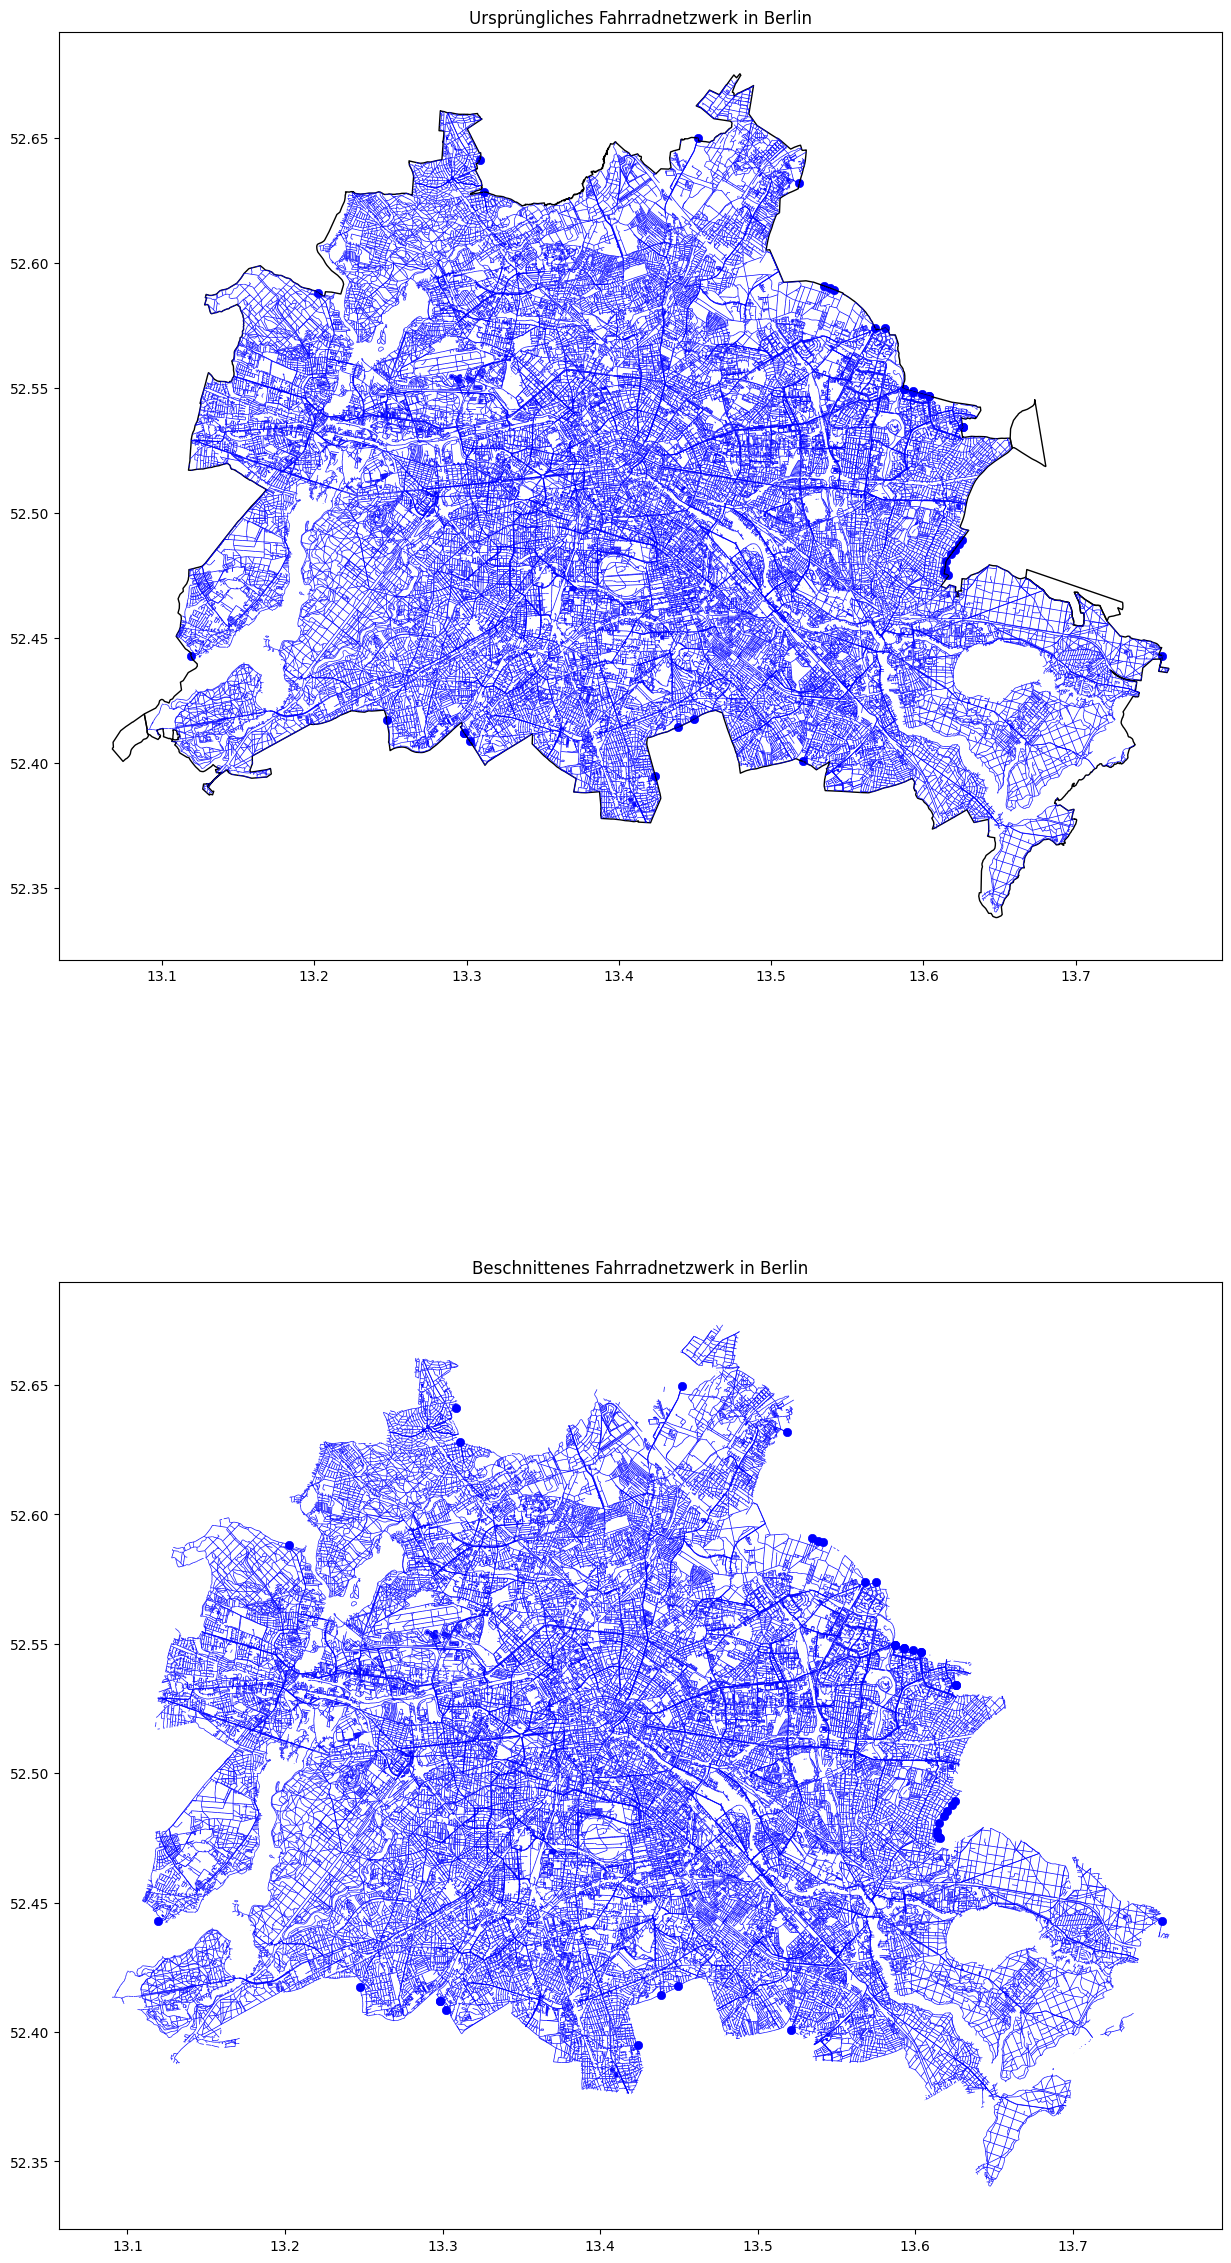

In [141]:
# Ursprüngliches Fahrradnetzwerk plotten
fig, ax = plt.subplots(2, 1, figsize=(15, 30))
cycle_net_berlin.plot(ax=ax[0], color='blue', linewidth=0.5)
ax[0].set_title('Ursprüngliches Fahrradnetzwerk in Berlin')

# Grenzen von Berlin plotten
boundaries.plot(ax=ax[0], color='none', edgecolor='black', linewidth=1)

# Beschnittene Geometrie plotten
geom = cycle_net_berlin.geometry.apply(lambda x: x.intersection(berlin_boundary))
filtered_geom = geom[~geom.is_empty]

# Plot the intersected geometries
filtered_geom.plot(ax=ax[1], color='blue', linewidth=0.5)
ax[1].set_title('Beschnittenes Fahrradnetzwerk in Berlin')

plt.show()

In [142]:
# Finden der leeren Geometrien 
leere_geometrien = cycle_net_berlin[cycle_net_berlin.geometry.is_empty]

print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 9968


### Entfernen leerer Geometrien
#### Nähere Erläuterungen dazu im notebook [osm_highway](osm_highway.ipynb)


In [143]:
# Entfernen von leeren Geometrien
cycle_net_berlin = cycle_net_berlin[~cycle_net_berlin.geometry.is_empty]

# Finden der leeren Geometrien 
leere_geometrien = cycle_net_berlin[cycle_net_berlin.geometry.is_empty]

print(f"Anzahl der leeren Geometrien: {len(leere_geometrien)}")

Anzahl der leeren Geometrien: 0


### Minimieren des Datensatzes auf relevante Spalten

für die weitere Verarbeitung wollen wir nur die Spalten "geometry" und die neu generierte Spalte "surface_category" behalten.

In [144]:
# Extrahieren der relevanten Spalten 
surfaces = cycle_net_berlin[['geometry', 'surface_category']]

In [145]:
# verschiedene Straßentypen und deren Häufigkeit im Netzwerk
surface_counts = surfaces['surface_category'].value_counts(normalize=True)*100
surface_counts

surface_category
paving_stone    34.546494
asphalt         33.367683
unpaved         26.185215
concrete         5.458033
sett             0.442575
Name: proportion, dtype: float64

### 4. Speichern der bereinigten Daten

In [147]:
# Speichern der bereinigten Daten
output_file_name = "../../data/processed_data/cycle_net_berlin_cleaned_surface.geojson"
surfaces.to_file(output_file_name, driver="GeoJSON")
print(f"Datei erfolgreich als GeoJSON gespeichert unter: {output_file_name}")

Datei erfolgreich als GeoJSON gespeichert unter: ../../data/processed_data/cycle_net_berlin_cleaned_surface.geojson


### 5. Überprüfung des gespeichterten Datensatzes

In [152]:
osm_surface = gpd.read_file("../../data/processed_data/cycle_net_berlin_cleaned_surface.geojson")

In [153]:
osm_surface.head()

surface_category                                           geometry
0          asphalt  MULTILINESTRING ((13.53136 52.49263, 13.53136 ...
1          unpaved  MULTILINESTRING ((13.52694 52.48969, 13.52639 ...
2          unpaved  MULTILINESTRING ((13.52477 52.48558, 13.52484 ...
3          asphalt  MULTILINESTRING ((13.45420 52.51571, 13.45431 ...
4          unpaved  MULTILINESTRING ((13.37261 52.59296, 13.37347 ...

### Visualisierung

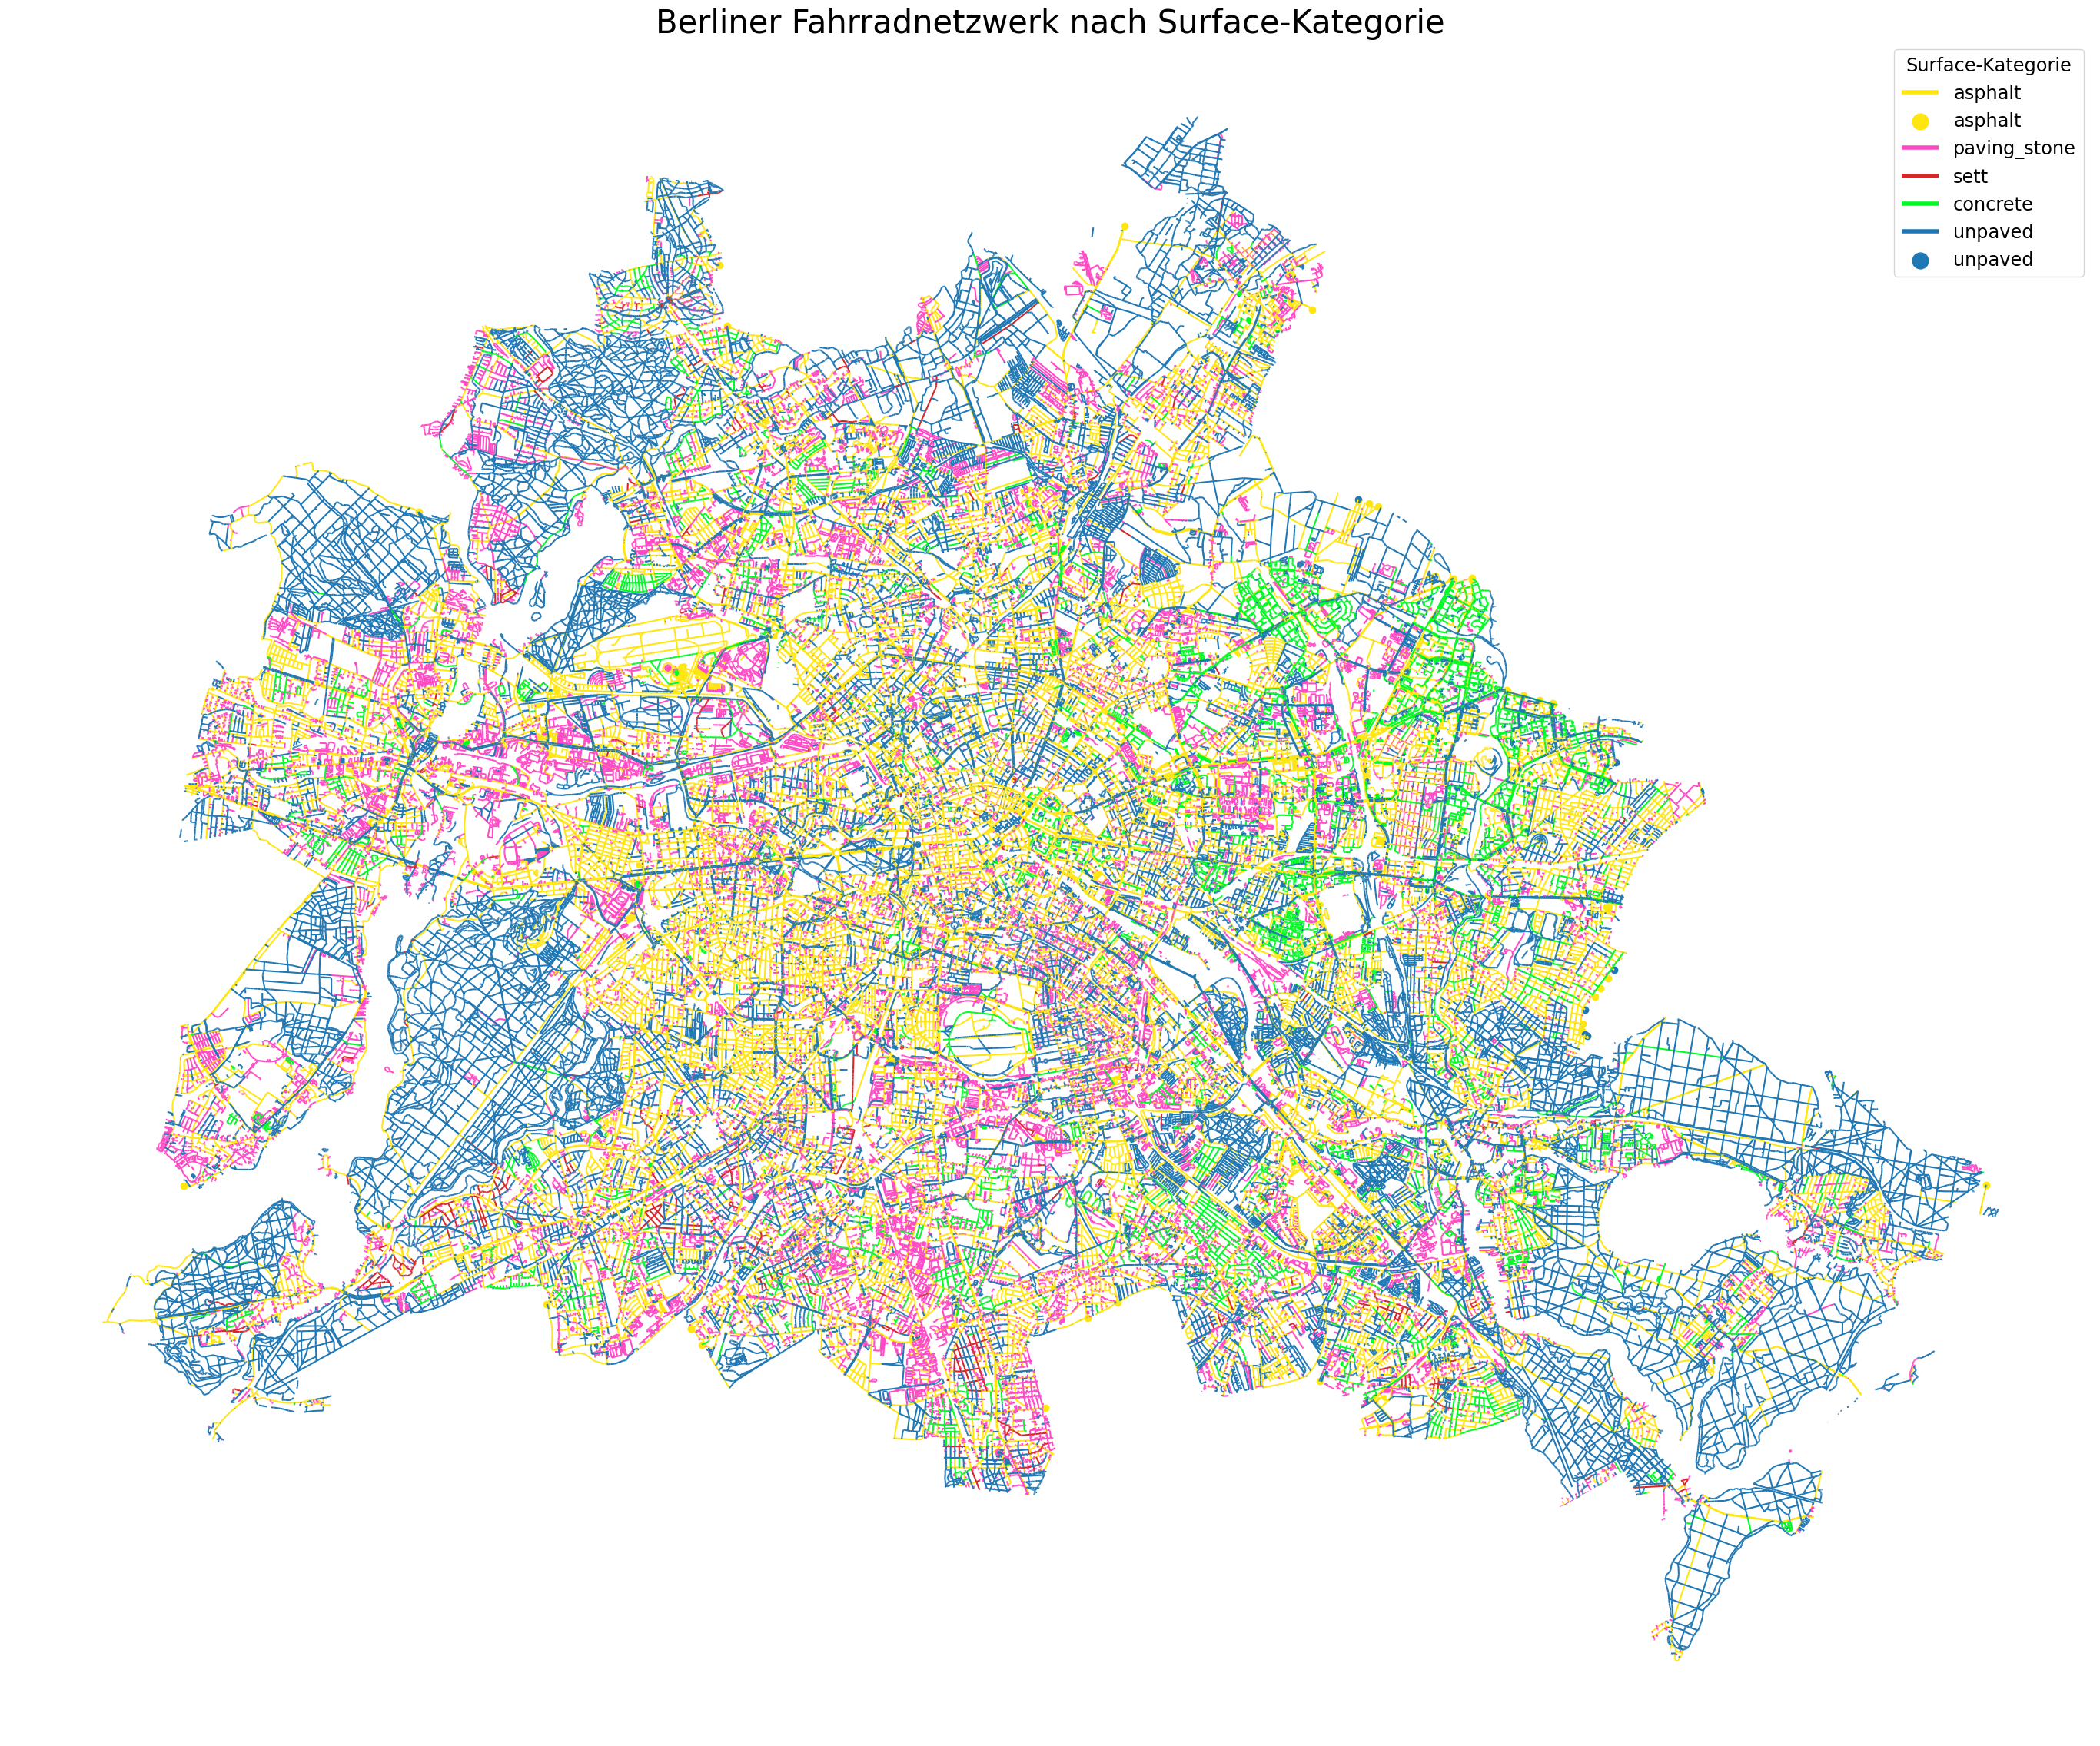

In [160]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Lade die GeoJSON-Datei
osm_surface = gpd.read_file("../../data/processed_data/cycle_net_berlin_cleaned_surface.geojson")

# Lade eine Hintergrundkarte von Berlin (optional)
# Hinweis: Du kannst auch einen WMS-Dienst oder eine andere Hintergrundkarte verwenden

# Definiere ein benutzerdefiniertes Farbschema für die Kategorien
custom_colors = {
    'asphalt': '#ffe611',      # Gelb
    'paving_stone': '#ff4ac6', # Pink
    'sett': '#d62728',         # Rot
    'concrete': '#00fc24',     # Grün
    'unpaved': '#1f77b4'       # Blau
}

# Erstelle eine neue Spalte mit den Farben basierend auf der 'surface_category'
osm_surface['color'] = osm_surface['surface_category'].map(custom_colors)

# Visualisiere die Daten
fig, ax = plt.subplots(1, 1, figsize=(35, 35))

# Plotten der GeoDataFrame mit benutzerdefinierten Farben
for category, color in custom_colors.items():
    subset = osm_surface[osm_surface['surface_category'] == category]
    subset.plot(ax=ax, color=color, label=category)

# Achsen entfernen
ax.set_axis_off()

# Titel hinzufügen
plt.title('Berliner Fahrradnetzwerk nach Surface-Kategorie', fontsize=30)

# Legende hinzufügen
#plt.legend(title='Surface-Kategorie')

# Legende hinzufügen und anpassen
legend = ax.legend(title='Surface-Kategorie', fontsize='xx-large', title_fontsize='xx-large', loc='upper right', markerscale=2)

# Größe der Legendenmarker anpassen
for legend_handle in legend.legend_handles:  # Verwendung von legend_handles statt legendHandles
    legend_handle.set_linewidth(4.0)

# Plot anzeigen
plt.show()


bei asphalt und bei unpaved gibt es  sowohl multilinestrings, linestrings, als auch Punkte in der gemometrie, deshalb weist die Legende zwei Typen auf...

In [171]:
# Zeige die verschiedenen Arten von geometrischen Objekten an
geometry_types = osm_surface.geometry.geom_type.unique()
print(geometry_types)

['MultiLineString' 'LineString' 'Point']


In [172]:
# Zähle alle geometrischen Objekte vom Typ "Point"
num_points = sum(osm_surface.geometry.geom_type == 'Point')

print(f"Anzahl der geometrischen Objekte vom Typ 'Point': {num_points}")


Anzahl der geometrischen Objekte vom Typ 'Point': 39


In [170]:
# Zähle die Anzahl der verschiedenen Geometrie-Typen
geometry_counts = osm_surface.geometry.geom_type.value_counts()

# Berechne die Prozentanteile
total_geometries = geometry_counts.sum()
geometry_percentages = (geometry_counts / total_geometries) * 100

# Anzeigen der Ergebnisse
print("Anzahl der verschiedenen Geometrie-Typen:")
print(geometry_counts)
print("\nProzentanteile der verschiedenen Geometrie-Typen:")
print(geometry_percentages)


Anzahl der verschiedenen Geometrie-Typen:
MultiLineString    121836
LineString          46006
Point                  39
Name: count, dtype: int64

Prozentanteile der verschiedenen Geometrie-Typen:
MultiLineString    72.572834
LineString         27.403935
Point               0.023231
Name: count, dtype: float64


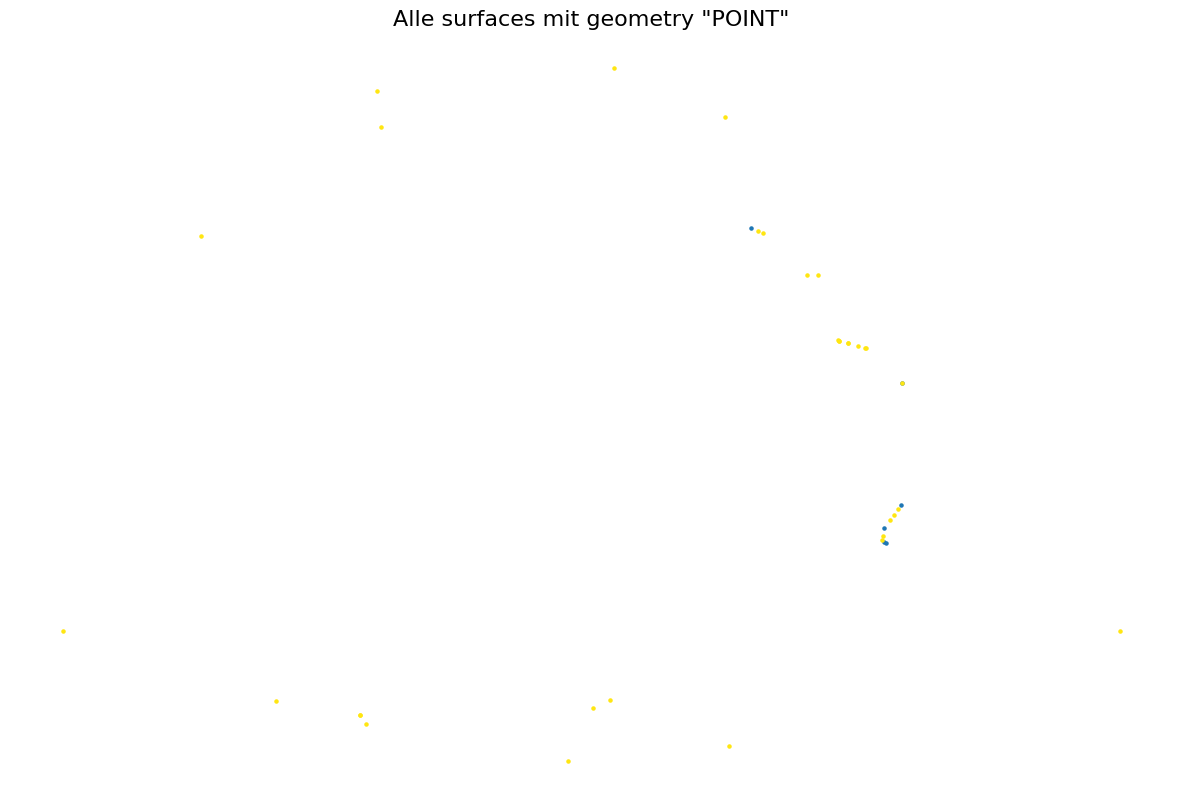

In [173]:
# Filtere nur geometrische Objekte vom Typ "Point"
points = osm_surface[osm_surface.geometry.geom_type == 'Point']

# Erstelle die Karte
fig, ax = plt.subplots(figsize=(15, 15))

# Plotte die Punkte nach ihren Farben
for color, group in points.groupby('color'):
    group.plot(ax=ax, color=color, markersize=5, label=color)

# Plotte die Punkte
#points.plot(ax=ax, color='red', markersize=5)

# Achsen entfernen
ax.set_axis_off()

# Titel hinzufügen
ax.set_title('Alle surfaces mit geometry "POINT"', fontsize=16)

# Karte anzeigen
plt.show()
